In [32]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [33]:
# load the dataset

# 法一
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

In [34]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3601, 500), (3601,), (1320, 500), (1320,))

In [35]:
# 法二

train = pd.read_csv(root_url + "FordA_TRAIN.tsv", sep='\t', header=None)
test = pd.read_csv(root_url + "FordA_TEST.tsv", sep='\t', header=None)

x_train, y_train = train.iloc[:, 1:].values, train.iloc[:, 0].values
x_test, y_test = test.iloc[:, 1:].values, test.iloc[:, 0].values

In [36]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3601, 500), (3601,), (1320, 500), (1320,))

In [37]:
x_train[y_train == 1].shape

(1755, 500)

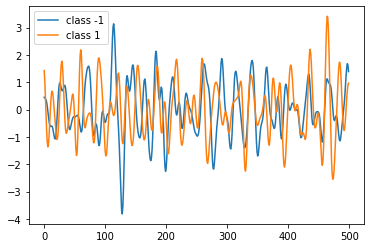

In [38]:
## 視覺化各一個class(從train data)來看看

classes = np.unique(np.concatenate([y_train, y_test]), axis=0)

plt.figure()
for cls in classes:
    x_train_one_example = x_train[y_train == cls][7]        # 挑一個!
    plt.plot(x_train_one_example, label=f'class {cls}')

plt.legend(loc='best')
plt.show()
plt.close()

### 資料處理
- 資料已經是類似一個標準常態分配, 故不用做標準化, 時間序列的標準化可以[參考](https://link.springer.com/article/10.1007/s10618-016-0483-9)
- 資料的permute
- DNN 時間序列模型需要資料type是多一個channel, 透過Reshape完成
- 因為label是-1, 1, 將-1改成0

In [40]:
# reshape

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], -1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], -1)

x_train.shape, x_test.shape

((3601, 500, 1), (1320, 500, 1))

In [41]:
num_classes = len(np.unique(y_train))

In [42]:
# 其實也可以.fit的時候shuffle=True
# permute

idx = np.random.permutation(len(train))
x_train = x_train[idx]
y_train = y_train[idx]

In [43]:
# label -1 ---> 0

y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

np.unique(y_train)

array([0, 1])

### 模型建立
- 參考(Time Series Classification from Scratch with Deep Neural Networks: A Strong Baseline)[https://arxiv.org/abs/1611.06455]

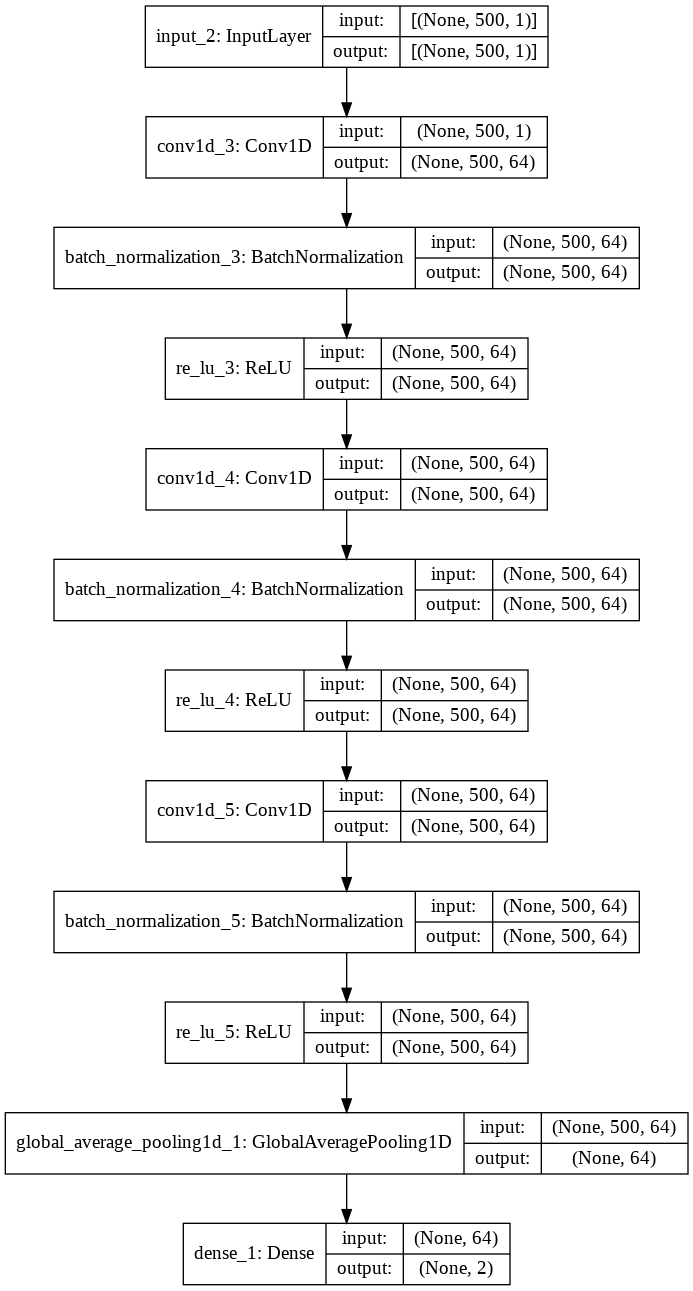

In [45]:
def make_model(input_shape, filters):
    input_layer = keras.layers.Input(shape=input_shape)

    conv1 = keras.layers.Conv1D(filters=filters, kernel_size=3, padding='same')(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=filters, kernel_size=3, padding='same')(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=filters, kernel_size=3, padding='same')(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)     # 相當於flatten的概念

    output_layer = keras.layers.Dense(units=num_classes, activation='softmax')(gap)

    return keras.Model(input_layer, output_layer)

model = make_model(input_shape=x_train.shape[1:], filters=64)
keras.utils.plot_model(model, show_shapes=True)

In [47]:
# 模型訓練

batch_size = 32
epochs = 500

# 存最好的、lr下降、提早停止
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.h5', save_best_only=True, monitor='val_loss'
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=50, verbose=1
    )
]

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
history = model.fit(
    x_train, y_train, batch_size, epochs, callbacks=callbacks, validation_split=0.2, verbose=1
)

Epoch 1/500
90/90 [==============================] - 33s 10ms/step - loss: 0.5680 - acc: 0.6788 - val_loss: 0.7810 - val_acc: 0.5021
Epoch 2/500
90/90 [==============================] - 1s 7ms/step - loss: 0.4817 - acc: 0.7653 - val_loss: 0.7801 - val_acc: 0.5021
Epoch 3/500
90/90 [==============================] - 1s 7ms/step - loss: 0.4397 - acc: 0.7764 - val_loss: 0.7331 - val_acc: 0.5021
Epoch 4/500
90/90 [==============================] - 1s 7ms/step - loss: 0.4272 - acc: 0.7903 - val_loss: 0.7466 - val_acc: 0.5187
Epoch 5/500
90/90 [==============================] - 1s 7ms/step - loss: 0.4037 - acc: 0.7993 - val_loss: 0.7610 - val_acc: 0.5520
Epoch 6/500
90/90 [==============================] - 1s 7ms/step - loss: 0.4027 - acc: 0.8045 - val_loss: 0.4325 - val_acc: 0.8169
Epoch 7/500
90/90 [==============================] - 1s 7ms/step - loss: 0.3972 - acc: 0.8066 - val_loss: 0.4433 - val_acc: 0.8072
Epoch 8/500
90/90 [==============================] - 1s 7ms/step - loss: 0.3972 -

In [49]:
## load model and  evaluate data

model = keras.models.load_model('best_model.h5')

test_loss, test_acc = model.evaluate(x_test, y_test)
print("測試分類正確率: ", test_acc)
print("測試資料loss: ", test_loss)

42/42 [==============================] - 0s 4ms/step - loss: 0.0924 - acc: 0.9697
測試分類正確率:  0.9696969985961914
測試資料loss:  0.09243414551019669


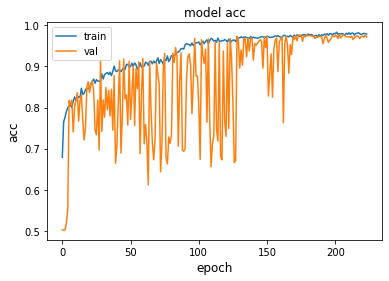

In [50]:
## 觀察訓練的情況, 主要針對效果以及overfitting

plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title("model acc")
plt.ylabel('acc', fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()